In [1]:
import numpy as np
import pandas as pd
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, ARDRegression, BayesianRidge, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve 
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context("paper", font_scale = 2)

In [2]:
#get file names for reading data
file_names = ["Reserves.csv"
,"Revenue_from_coal.csv"
,"Revenue_from_forest.csv"
,"Roadways.csv"
,"Tobacco_use.csv"
,"Telephone_lines.csv"
,"Telephone_mobile.csv"
,"Total_fertility_rate.csv"
,"Unemployment_rate.csv"
,"Waterways.csv"
,"Youth_unemployment.csv"
,"Airports.csv"
,"Area.csv"
,"Birth_rate.csv"
,"Broadband_subscriptions.csv"
,"Budget_surplus_deficit.csv"
,"Carbon_emissions.csv"
,"Children_underweight.csv"
,"Current_account.csv"
,"Death_rate.csv"
,"Debt.csv"
,"Education_expenditure.csv"
,"Energy_consumption_per_capita.csv"
,"Exports.csv"
,"Gini_index_coefficient.csv"
,"Gov_revenue.csv"
,"Hiv_aids_deaths.csv"
,"Hiv_aids_num.csv"
,"Hiv_aids_rate.csv"
,"Imports.csv"
,"Industrial_growth_rate.csv"
,"Infant_mortality_rate.csv"
,"Inflation_rate.csv"
,"Internet_users.csv"
,"Labor_force.csv"
,"Life_expectancy.csv"
,"Maternal_mortality_ratio.csv"
,"Median_age.csv"
,"Merchant_marine.csv"
,"Military_expenditures.csv"
,"Net_mig_rate.csv"
,"Obesity_rate.csv"
,"Petrol_exports.csv"
,"Petrol_imports.csv"
,"Petrol_production.csv"
,"Pop_growth_rate.csv"
,"Population.csv"
,"Public_debt.csv"
,"Railways.csv"
,"Real_GDP.csv"
,"Real_GDP_growth.csv"
,"Real_GDP_per_capita.csv"]

In [3]:
#HDI target variable
HDI = pd.read_excel("data/HDI.xlsx", header = None)[[1, 2]]
HDI.columns = ["Name", "HDI"]
HDI

,Name,HDI
0,Norway,0.957
1,Ireland,0.955
2,Switzerland,0.955
3,Hong Kong,0.949
4,Iceland,0.949
...,...,...
184,Burundi,0.433
185,South Sudan,0.433
186,Chad,0.398
187,Central African Republic,0.397


In [4]:
#list of DataFrames to merge together later
df_list = []

for name in file_names:
    df = pd.read_csv("data/" + name).drop(['slug', 'date_of_information', 'ranking'], axis = 1)
    df = df.rename(columns = {'value':name.replace('.csv', ''), 'name':"Name", 'region':"Region"})
    df_list.append(df)

In [5]:
#credit: https://www.statology.org/pandas-merge-multiple-dataframes/
#all data merged into one DataFrame
from functools import reduce

#merge all DataFrames into one
cia = reduce(lambda  left,right: pd.merge(left,right,on=['Name', 'Region'],
                                            how='outer'), df_list)
cia = cia.merge(HDI, on = "Name", how = 'inner')
cia.index = cia["Name"]
cia = cia.drop("Name", axis = 1)

In [8]:
cia.to_csv("cia.csv")
cia

,Reserves,Region,Revenue_from_coal,Revenue_from_forest,Roadways,Tobacco_use,Telephone_lines,Telephone_mobile,Total_fertility_rate,Unemployment_rate,...,Petrol_imports,Petrol_production,Pop_growth_rate,Population,Public_debt,Railways,Real_GDP,Real_GDP_growth,Real_GDP_per_capita,HDI
Name,,,,,,,,,,,,,,,,,,,,,
China,"$3,236,000,000,000",East and Southeast Asia,0.57,0.08,"5,200,000",25.6,"181,908,000","1,720,000,000",1.45,3.64,...,"1,160,000","11,510,000",0.19,"1,410,539,758",47.0,"150,000.0","$23,009,780,000,000",6.14,"$16,400",0.761
Japan,"$1,264,000,000,000",East and Southeast Asia,0.00,0.02,"1,218,772",20.1,"61,978,594","195,054,893",1.38,2.36,...,"1,100,000","3,467,000",-0.39,"124,214,766",237.6,"27,311.0","$5,224,850,000,000",0.70,"$41,400",0.919
Switzerland,"$811,200,000,000",Europe,0.00,0.01,"71,557",25.5,"3,071,296","10,829,000",1.58,2.31,...,"165,100","61,550",0.65,"8,508,698",41.8,"5,466.0","$590,710,000,000",1.11,"$68,400",0.955
Saudi Arabia,"$496,400,000,000",Middle East,0.00,0.00,"221,372",14.3,"5,749,058","43,215,439",1.92,6.00,...,"609,600","2,476,000",1.63,"35,354,380",17.2,"5,410.0","$1,543,240,000,000",-0.90,"$44,300",0.854
Russia,"$432,700,000,000",Central Asia,0.53,0.29,"1,283,387",26.8,"25,892,405","238,733,217",1.60,4.60,...,"41,920","6,076,000",-0.22,"142,021,981",15.5,"87,157.0","$3,875,690,000,000",1.34,"$26,500",0.824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Solomon Islands,$0,Australia and Oceania,0.00,20.27,"1,390",36.5,"7,000","478,116",2.87,NaN,...,"1,577",0,1.72,"702,694",9.4,NaN,"$1,710,000,000",3.50,"$2,500",0.567
Antigua and Barbuda,NaN,Central America and the Caribbean,0.00,0.00,"1,170",NaN,"27,000","184,000",1.95,11.00,...,"5,065",0,1.15,"100,335",86.8,NaN,"$1,760,000,000",2.80,"$18,000",0.778
Andorra,NaN,Europe,NaN,0.00,320,31.8,"40,000","94,000",1.45,3.70,...,NaN,0,-0.10,"85,560",41.0,NaN,"$3,327,000,000",-1.10,"$49,900",0.868


In [7]:
#null values present
#incorrect Dtypes for some columns
cia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, China to Marshall Islands
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Reserves                       176 non-null    object 
 1   Region                         180 non-null    object 
 2   Revenue_from_coal              171 non-null    float64
 3   Revenue_from_forest            177 non-null    float64
 4   Roadways                       175 non-null    object 
 5   Tobacco_use                    153 non-null    float64
 6   Telephone_lines                178 non-null    object 
 7   Telephone_mobile               180 non-null    object 
 8   Total_fertility_rate           180 non-null    float64
 9   Unemployment_rate              174 non-null    float64
 10  Waterways                      109 non-null    object 
 11  Youth_unemployment             160 non-null    float64
 12  Airports                       178 non

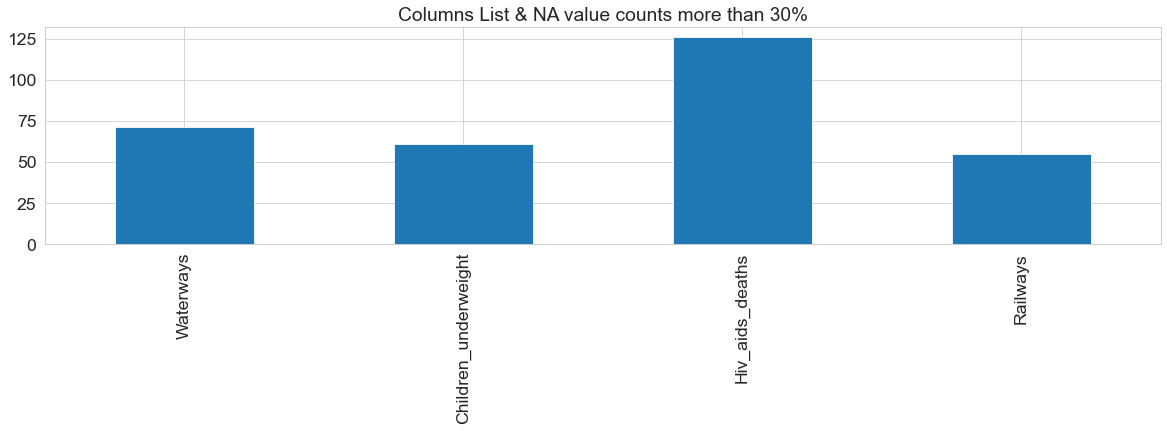

In [8]:
#credit: https://www.analyticsvidhya.com/blog/2021/06/eda-exploratory-data-analysis-with-python/#h2_3
#removing columns with too many null values (30%)
NA_col = cia.isnull().sum()
NA_col = NA_col[NA_col.values >(0.3*len(cia))]
plt.figure(figsize=(20,4))
NA_col.plot(kind='bar')
plt.title('Columns List & NA value counts more than 30%')
plt.show()

In [9]:
#columns with too many null values dropped
cia = cia.drop(["Waterways", "Children_underweight", "Hiv_aids_deaths", "Railways"], axis = 1)

In [10]:
#columns to be converted to numeric type
cia_object_cols = cia.columns[cia.dtypes == object].drop(["Region"])
cia_object_cols

Index(['Reserves', 'Roadways', 'Telephone_lines', 'Telephone_mobile',
       'Airports', 'Area', 'Broadband_subscriptions', 'Carbon_emissions',
       'Current_account', 'Debt', 'Energy_consumption_per_capita', 'Exports',
       'Hiv_aids_num', 'Imports', 'Inflation_rate', 'Internet_users',
       'Labor_force', 'Maternal_mortality_ratio', 'Merchant_marine',
       'Petrol_exports', 'Petrol_imports', 'Petrol_production', 'Population',
       'Real_GDP', 'Real_GDP_per_capita'],
      dtype='object')

In [11]:
#preprocess object columns that should be numeric
for col in cia_object_cols:
    cia[col] = pd.to_numeric(cia[col].str.replace(",", "").str.replace("$", ""))
first_column = cia.pop('Region')
cia.insert(0, 'Region', first_column)
cia

<ipython-input-11-da3734535305>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  cia[col] = pd.to_numeric(cia[col].str.replace(",", "").str.replace("$", ""))


,Region,Reserves,Revenue_from_coal,Revenue_from_forest,Roadways,Tobacco_use,Telephone_lines,Telephone_mobile,Total_fertility_rate,Unemployment_rate,...,Petrol_exports,Petrol_imports,Petrol_production,Pop_growth_rate,Population,Public_debt,Real_GDP,Real_GDP_growth,Real_GDP_per_capita,HDI
Name,,,,,,,,,,,,,,,,,,,,,
China,East and Southeast Asia,3.236000e+12,0.57,0.08,5200000.0,25.6,181908000.0,1720000000,1.45,3.64,...,848400.0,1160000.0,11510000.0,0.19,1410539758,47.0,23009780000000,6.14,16400,0.761
Japan,East and Southeast Asia,1.264000e+12,0.00,0.02,1218772.0,20.1,61978594.0,195054893,1.38,2.36,...,370900.0,1100000.0,3467000.0,-0.39,124214766,237.6,5224850000000,0.70,41400,0.919
Switzerland,Europe,8.112000e+11,0.00,0.01,71557.0,25.5,3071296.0,10829000,1.58,2.31,...,7345.0,165100.0,61550.0,0.65,8508698,41.8,590710000000,1.11,68400,0.955
Saudi Arabia,Middle East,4.964000e+11,0.00,0.00,221372.0,14.3,5749058.0,43215439,1.92,6.00,...,1784000.0,609600.0,2476000.0,1.63,35354380,17.2,1543240000000,-0.90,44300,0.854
Russia,Central Asia,4.327000e+11,0.53,0.29,1283387.0,26.8,25892405.0,238733217,1.60,4.60,...,2671000.0,41920.0,6076000.0,-0.22,142021981,15.5,3875690000000,1.34,26500,0.824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Solomon Islands,Australia and Oceania,0.000000e+00,0.00,20.27,1390.0,36.5,7000.0,478116,2.87,NaN,...,0.0,1577.0,0.0,1.72,702694,9.4,1710000000,3.50,2500,0.567
Antigua and Barbuda,Central America and the Caribbean,NaN,0.00,0.00,1170.0,NaN,27000.0,184000,1.95,11.00,...,91.0,5065.0,0.0,1.15,100335,86.8,1760000000,2.80,18000,0.778
Andorra,Europe,NaN,NaN,0.00,320.0,31.8,40000.0,94000,1.45,3.70,...,NaN,NaN,0.0,-0.10,85560,41.0,3327000000,-1.10,49900,0.868


In [12]:
#numeric type columns now correct Dtype
cia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, China to Marshall Islands
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Region                         180 non-null    object 
 1   Reserves                       176 non-null    float64
 2   Revenue_from_coal              171 non-null    float64
 3   Revenue_from_forest            177 non-null    float64
 4   Roadways                       175 non-null    float64
 5   Tobacco_use                    153 non-null    float64
 6   Telephone_lines                178 non-null    float64
 7   Telephone_mobile               180 non-null    int64  
 8   Total_fertility_rate           180 non-null    float64
 9   Unemployment_rate              174 non-null    float64
 10  Youth_unemployment             160 non-null    float64
 11  Airports                       178 non-null    float64
 12  Area                           180 non

In [13]:
cia.describe()

,Reserves,Revenue_from_coal,Revenue_from_forest,Roadways,Tobacco_use,Telephone_lines,Telephone_mobile,Total_fertility_rate,Unemployment_rate,Youth_unemployment,...,Petrol_exports,Petrol_imports,Petrol_production,Pop_growth_rate,Population,Public_debt,Real_GDP,Real_GDP_growth,Real_GDP_per_capita,HDI
count,1.760000e+02,171.00000,177.000000,1.750000e+02,153.000000,1.780000e+02,1.800000e+02,180.000000,174.000000,160.000000,...,1.770000e+02,1.760000e+02,1.780000e+02,180.000000,1.800000e+02,179.000000,1.800000e+02,180.000000,180.000000,180.000000
mean,6.923077e+10,0.15269,1.185367,2.243123e+05,20.026797,4.874809e+06,4.438390e+07,2.453500,10.177356,18.858125,...,1.750720e+05,1.566024e+05,4.946362e+05,1.024833,4.142970e+07,56.849721,6.701396e+11,2.814111,20457.244444,0.728389
std,2.772033e+11,0.76794,2.525553,8.187862e+05,9.386644,1.726892e+07,1.618072e+08,1.141958,10.513022,12.197662,...,5.438003e+05,3.482035e+05,1.889391e+06,1.071301,1.527151e+08,33.361918,2.425206e+12,5.609679,22016.466485,0.149520
min,0.000000e+00,0.00000,0.000000,9.300000e+01,3.500000,0.000000e+00,1.600000e+04,1.100000,0.300000,0.400000,...,0.000000e+00,0.000000e+00,0.000000e+00,-1.120000,2.169500e+04,0.100000,2.400000e+08,-19.670000,700.000000,0.394000
25%,7.598750e+08,0.00000,0.020000,6.539500e+03,11.800000,6.307425e+04,1.913618e+06,1.687500,3.792500,10.000000,...,0.000000e+00,9.238500e+03,0.000000e+00,0.267500,2.123504e+06,36.400000,2.302750e+10,1.250000,4775.000000,0.611000
50%,5.789000e+09,0.00000,0.180000,3.108300e+04,20.300000,4.318940e+05,8.103248e+06,2.005000,6.590000,16.500000,...,3.871000e+03,3.424500e+04,1.500000e+04,0.895000,8.802847e+06,50.900000,7.689500e+10,2.500000,12400.000000,0.746000
75%,3.652750e+10,0.01000,1.120000,9.854850e+04,25.600000,2.598964e+06,2.448749e+07,2.872500,11.775000,25.075000,...,6.412000e+04,1.233000e+05,2.318500e+05,1.642500,3.000895e+07,70.850000,3.816950e+11,4.557500,29075.000000,0.845750
max,3.236000e+12,8.62000,20.270000,6.586610e+06,40.600000,1.819080e+08,1.720000e+09,6.820000,77.000000,73.000000,...,5.218000e+06,2.335000e+06,2.030000e+07,4.910000,1.410540e+09,237.600000,2.300978e+13,64.000000,139100.000000,0.957000


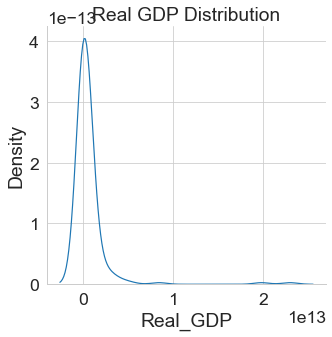

In [14]:
#EDA
sns.displot(data=cia, x = "Real_GDP", kind = "kde")
plt.title('Real GDP Distribution')
plt.show()

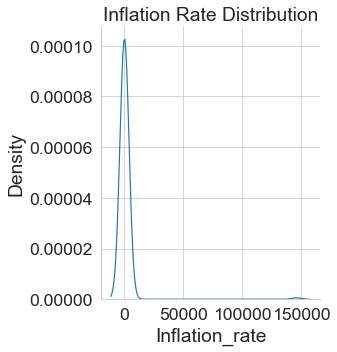

In [15]:
#seemingly normal distribution other than outliers
sns.displot(data=cia, x = "Inflation_rate", kind = "kde")
plt.title('Inflation Rate Distribution')
plt.show()

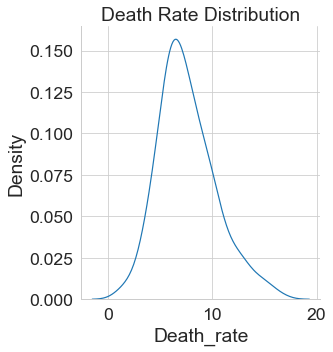

In [16]:
sns.displot(data=cia, x = "Death_rate", kind = "kde")
plt.title('Death Rate Distribution')
plt.show()

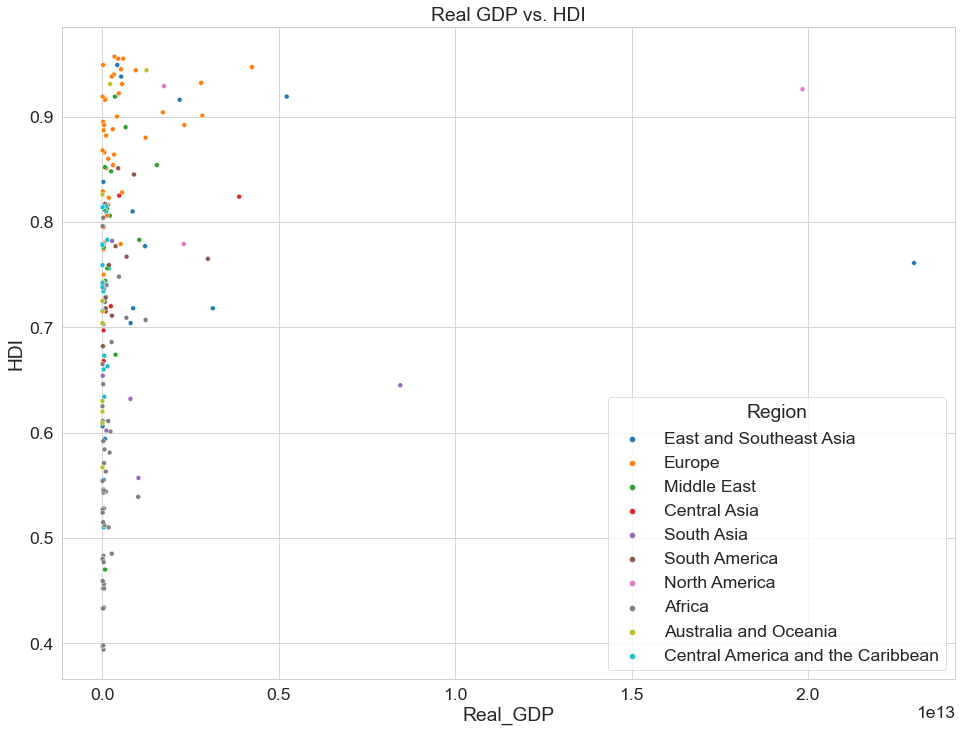

In [17]:
#GDP not very correlated
plt.figure(figsize=(16,12))
sns.scatterplot(data = cia, x='Real_GDP', y='HDI', hue ='Region')
plt.title('Real GDP vs. HDI')
plt.show()

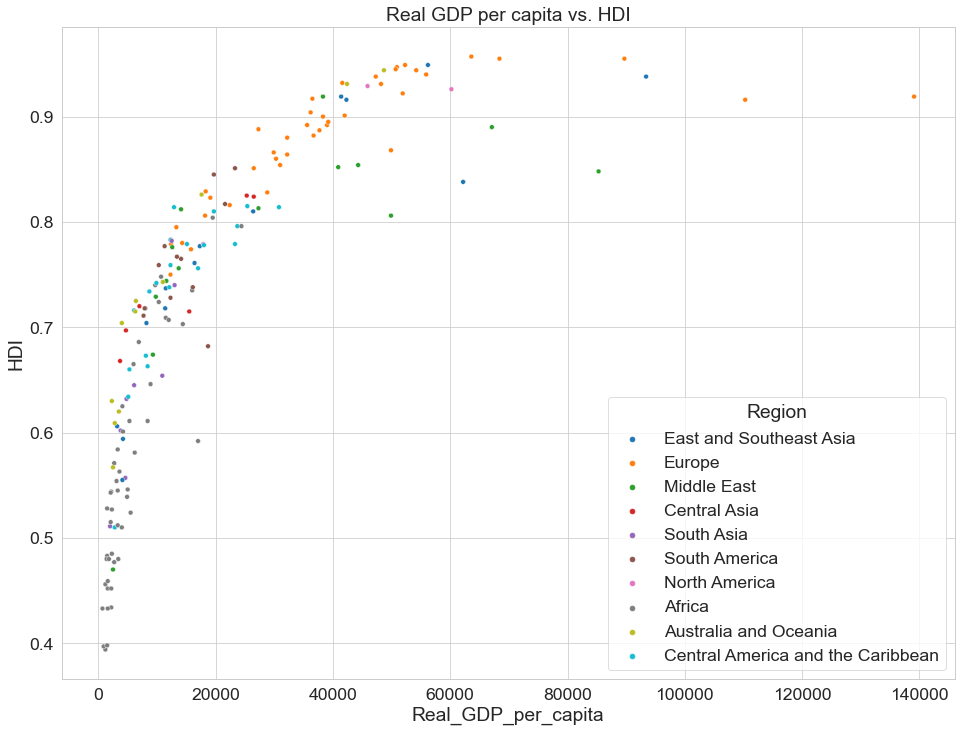

In [18]:
#some correlation
plt.figure(figsize=(16,12))
sns.scatterplot(data = cia, x='Real_GDP_per_capita', y='HDI', hue ='Region')
plt.title('Real GDP per capita vs. HDI')
plt.show()

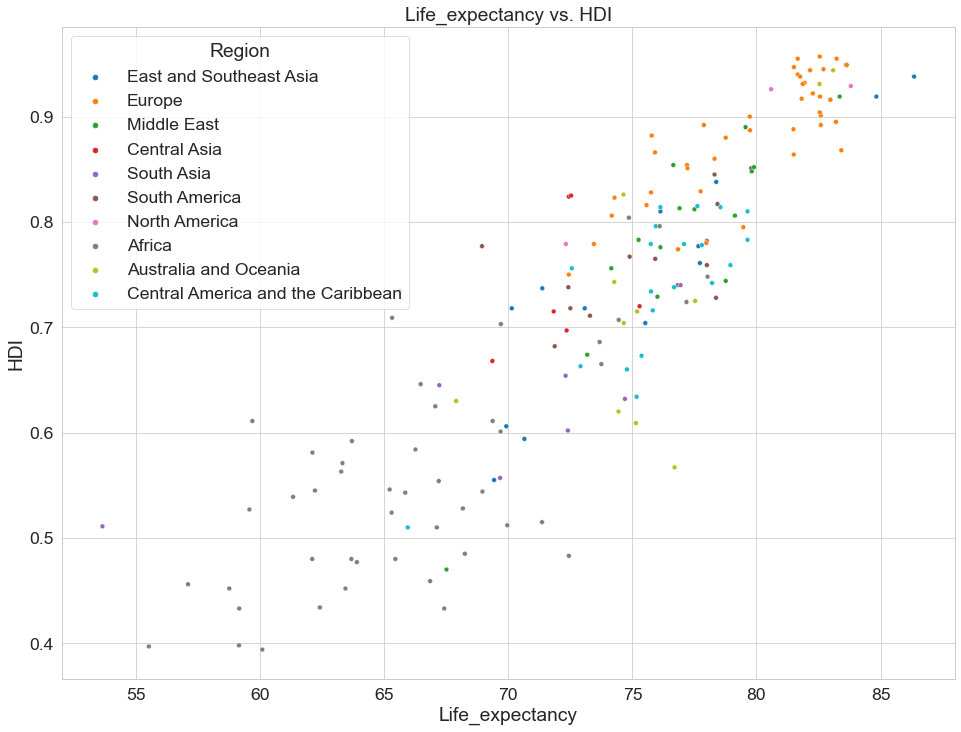

In [19]:
#higher correlation
plt.figure(figsize=(16,12))
sns.scatterplot(data = cia, x='Life_expectancy', y='HDI', hue ='Region')
plt.title('Life_expectancy vs. HDI')
plt.show()

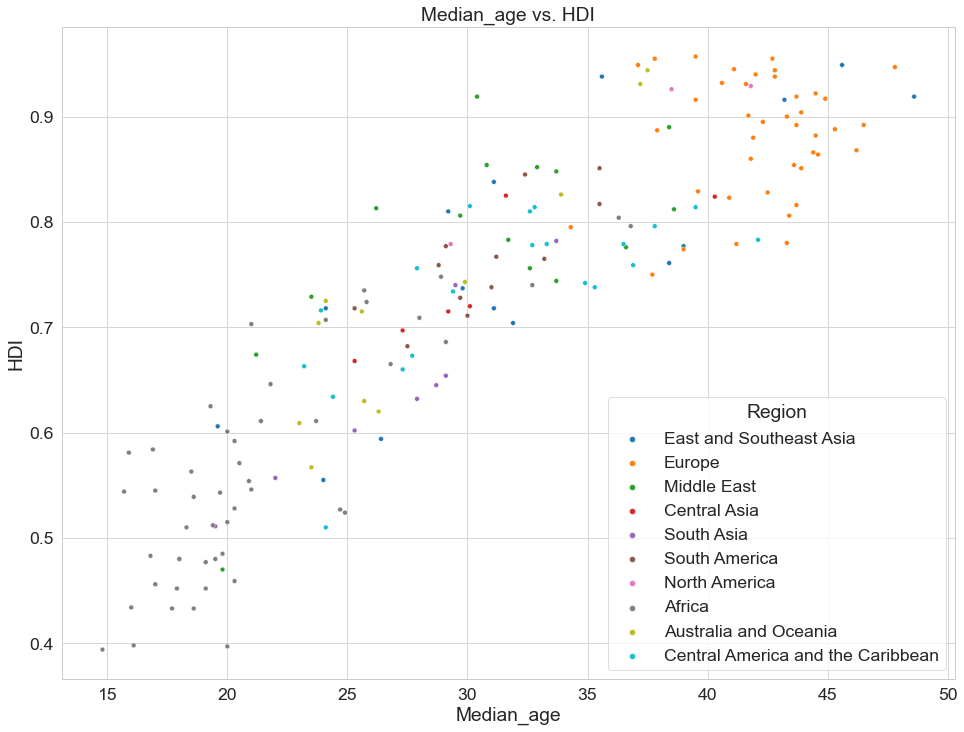

In [20]:
plt.figure(figsize=(16,12))
sns.scatterplot(data = cia, x='Median_age', y='HDI', hue ='Region')
plt.title('Median_age vs. HDI')
plt.show()

In [21]:
#encode categorical variables ("Region" column)
le = LabelEncoder()
cia["Region"] = le.fit_transform(cia["Region"])
cia

,Region,Reserves,Revenue_from_coal,Revenue_from_forest,Roadways,Tobacco_use,Telephone_lines,Telephone_mobile,Total_fertility_rate,Unemployment_rate,...,Petrol_exports,Petrol_imports,Petrol_production,Pop_growth_rate,Population,Public_debt,Real_GDP,Real_GDP_growth,Real_GDP_per_capita,HDI
Name,,,,,,,,,,,,,,,,,,,,,
China,4,3.236000e+12,0.57,0.08,5200000.0,25.6,181908000.0,1720000000,1.45,3.64,...,848400.0,1160000.0,11510000.0,0.19,1410539758,47.0,23009780000000,6.14,16400,0.761
Japan,4,1.264000e+12,0.00,0.02,1218772.0,20.1,61978594.0,195054893,1.38,2.36,...,370900.0,1100000.0,3467000.0,-0.39,124214766,237.6,5224850000000,0.70,41400,0.919
Switzerland,5,8.112000e+11,0.00,0.01,71557.0,25.5,3071296.0,10829000,1.58,2.31,...,7345.0,165100.0,61550.0,0.65,8508698,41.8,590710000000,1.11,68400,0.955
Saudi Arabia,6,4.964000e+11,0.00,0.00,221372.0,14.3,5749058.0,43215439,1.92,6.00,...,1784000.0,609600.0,2476000.0,1.63,35354380,17.2,1543240000000,-0.90,44300,0.854
Russia,3,4.327000e+11,0.53,0.29,1283387.0,26.8,25892405.0,238733217,1.60,4.60,...,2671000.0,41920.0,6076000.0,-0.22,142021981,15.5,3875690000000,1.34,26500,0.824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Solomon Islands,1,0.000000e+00,0.00,20.27,1390.0,36.5,7000.0,478116,2.87,NaN,...,0.0,1577.0,0.0,1.72,702694,9.4,1710000000,3.50,2500,0.567
Antigua and Barbuda,2,NaN,0.00,0.00,1170.0,NaN,27000.0,184000,1.95,11.00,...,91.0,5065.0,0.0,1.15,100335,86.8,1760000000,2.80,18000,0.778
Andorra,5,NaN,NaN,0.00,320.0,31.8,40000.0,94000,1.45,3.70,...,NaN,NaN,0.0,-0.10,85560,41.0,3327000000,-1.10,49900,0.868


In [22]:
#Train/test data split
X = cia.drop("HDI", axis = 1)
y = cia.HDI
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, shuffle = True, random_state = 0)
X_train

,Region,Reserves,Revenue_from_coal,Revenue_from_forest,Roadways,Tobacco_use,Telephone_lines,Telephone_mobile,Total_fertility_rate,Unemployment_rate,...,Obesity_rate,Petrol_exports,Petrol_imports,Petrol_production,Pop_growth_rate,Population,Public_debt,Real_GDP,Real_GDP_growth,Real_GDP_per_capita
Name,,,,,,,,,,,,,,,,,,,,,
New Zealand,1,2.068000e+10,0.03,0.50,94000.0,13.7,858000.0,6148000,1.86,4.13,...,30.8,1782.0,56000.0,115100.0,1.17,5053004,31.7,215600000000,2.22,42400
Dominican Republic,2,6.873000e+09,0.00,0.03,19705.0,10.6,1155493.0,8989587,2.21,5.10,...,27.6,0.0,108500.0,16060.0,0.91,10694700,37.2,184450000000,4.60,17000
Kuwait,6,3.370000e+10,0.00,0.00,5749.0,17.9,583463.0,6770346,2.24,1.10,...,37.9,705500.0,0.0,915800.0,1.17,3068155,20.6,209740000000,-3.30,49900
Sudan,0,1.980000e+08,0.00,3.01,31000.0,NaN,129408.0,33014200,4.60,19.60,...,6.6,8541.0,24340.0,94830.0,2.55,47958856,121.6,176400000000,1.40,4000
Montenegro,5,1.077000e+09,0.12,0.43,7762.0,31.4,191768.0,1080089,1.81,15.82,...,23.3,357.0,6448.0,0.0,-0.41,604966,67.2,11360000000,4.30,18300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ethiopia,0,3.013000e+09,0.00,5.81,120171.0,5.1,1252000.0,44500000,3.99,17.50,...,4.5,0.0,69970.0,0.0,2.46,113656596,54.2,264050000000,10.90,2300
Guatemala,2,1.177000e+10,0.00,0.78,17440.0,10.9,2272467.0,20390671,2.62,2.30,...,21.2,10810.0,97900.0,1162.0,1.58,17703190,24.7,141500000000,2.80,8400
Madagascar,0,1.600000e+09,0.00,4.34,31640.0,27.8,69000.0,15869000,3.62,1.80,...,5.3,0.0,18880.0,0.0,2.27,28172462,36.0,41820000000,4.20,1500


In [23]:
#preprocessing pipeline to help prevent data leakage during cross-validation
ct = make_pipeline(KNNImputer(), make_column_transformer((RobustScaler(), slice(1, 48)), remainder = 'passthrough'))

In [24]:
#Baseline model performance 
#overfitting
baseline = make_pipeline(ct, LinearRegression())
baseline.fit(X_train, y_train)
baseline_y_test_pred = baseline.predict(X_test)
baseline_y_train_pred = baseline.predict(X_train)
baseline_train_error = mean_absolute_error(y_train, baseline_y_train_pred)
baseline_test_error = mean_absolute_error(y_test, baseline_y_test_pred)
baseline_train_error, baseline_test_error, baseline_test_error - baseline_train_error

(0.023134620502931233, 0.14290101163076804, 0.11976639112783681)

Text(0.5, 1.0, 'Correlation Heatmap')

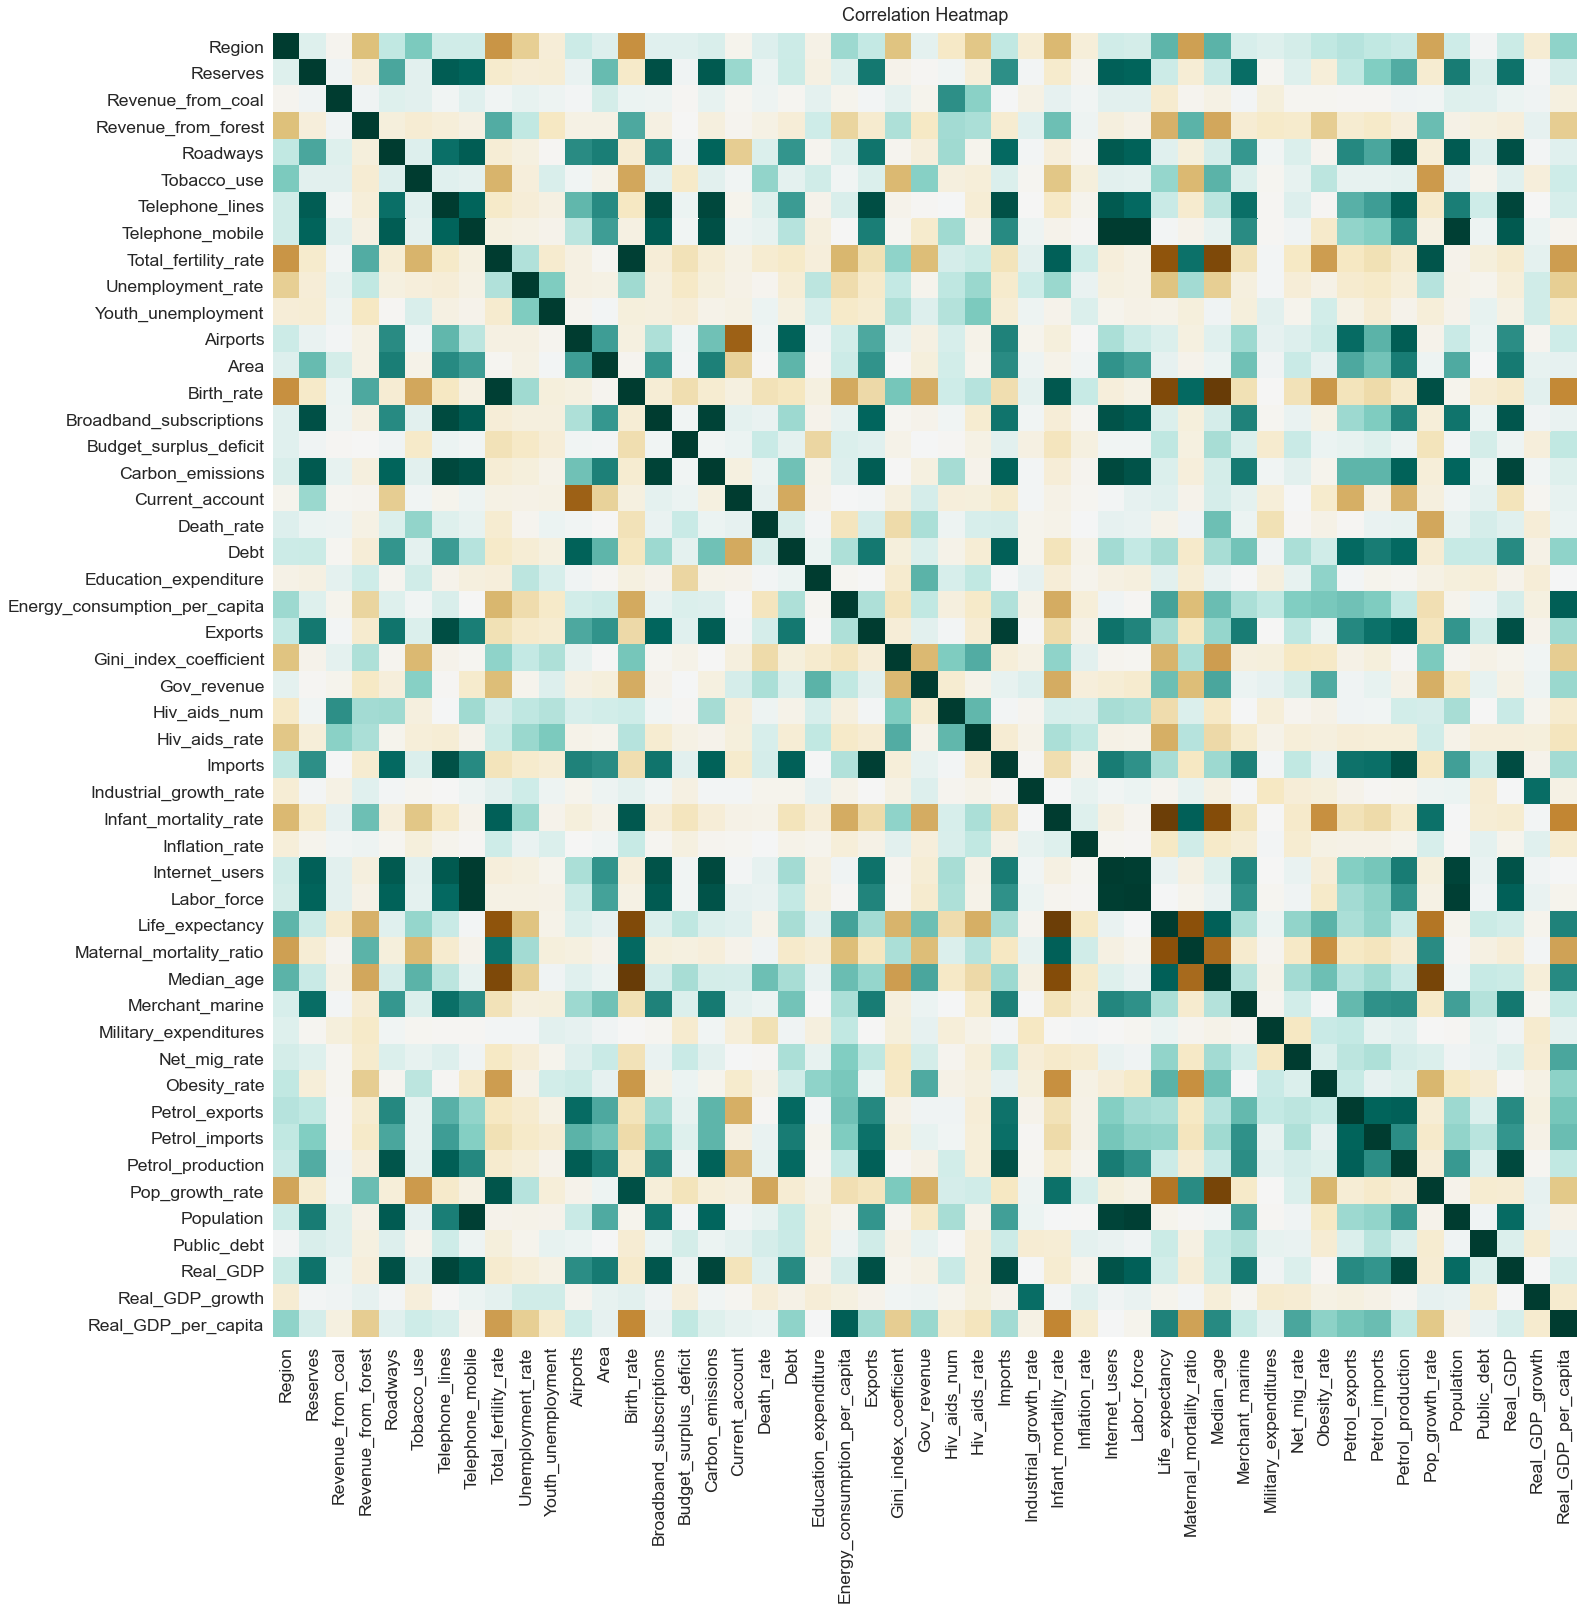

In [25]:
#correlation heatmap to see highly correlated features
plt.figure(figsize=(34, 24))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, cmap='BrBG', annot = False, square = True, cbar = False)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

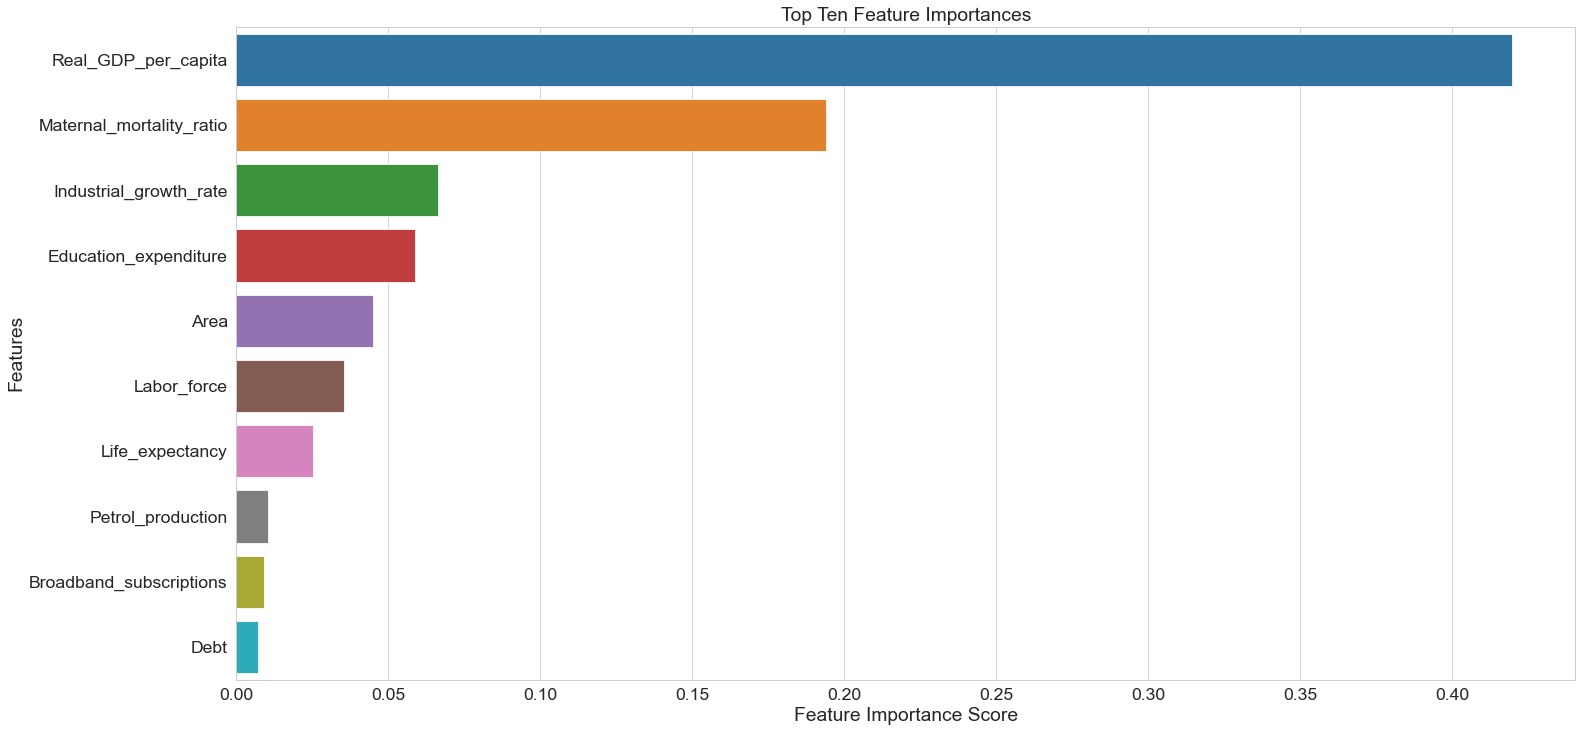

In [26]:
#feature importances to choose features for vif feature selection
plt.figure(figsize=(24, 12))
#fitting RF for feature importance
rf1 = make_pipeline(ct, RandomForestRegressor(n_estimators=100, random_state = 1, criterion = 'absolute_error'))
rf1.fit(X_train, y_train)
feature_imp = pd.Series(rf1.named_steps.randomforestregressor.feature_importances_,index=X.columns).sort_values(ascending=False)
# Creating a bar plot
sns.barplot(x=feature_imp[0:10], y=feature_imp.index[0:10])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Top Ten Feature Importances")
plt.show()

In [27]:
#function to run vif feature selection automatically so that vif values are below 5 therefore preventing multicollinearity
def vif_FS(top_feature, corr_features):
    cols = X_train.columns
    idx = X_train.index
    X_train_scaled = pd.DataFrame(ct.fit_transform(X_train))
    X_train_scaled.columns = cols
    X_train_scaled.index = idx
    features = X.columns.drop(corr_features)
    y_vif, X_vif = dmatrices('HDI' + ' ~' + "+".join(features), 
                             X_train.assign(HDI = y_train), return_type='dataframe')
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    vif["features"] = X_vif.columns
    vif = vif.sort_values('VIF', ascending = False)
    while max(vif.VIF) >= 5:
        features = features.drop(vif.drop([0, list(vif[vif["features"] == top_feature].index)[0]]).iloc[0]["features"])
        y_vif, X_vif = dmatrices('HDI ~' + "+".join(features), 
                                 X_train_scaled.assign(HDI = y_train), return_type='dataframe')
        vif = pd.DataFrame()
        vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
        vif["features"] = X_vif.columns
        vif = vif.round(1).sort_values('VIF', ascending = False)
    sm.add_constant(X_vif)
    linreg = sm.OLS(y_vif, X_vif).fit()
    print(linreg.summary())
    return vif

In [28]:
#top 4 features from rf feature importances used to create 4 seperate feature sets
features_Real_GDP_per_capita = vif_FS("Real_GDP_per_capita", corr_features = [])["features"].drop(0)
features_Education_expenditure = vif_FS("Education_expenditure", corr_features = [])["features"].drop(0)
features_Industrial_growth_rate = vif_FS("Industrial_growth_rate", corr_features = [])["features"].drop(0)
features_Maternal_mortality_ratio = vif_FS("Maternal_mortality_ratio", corr_features = [])["features"].drop(0)

C:\Users\Justin\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                    HDI   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     32.92
Date:                Thu, 25 Aug 2022   Prob (F-statistic):           3.62e-38
Time:                        21:35:56   Log-Likelihood:                 187.86
No. Observations:                 144   AIC:                            -339.7
Df Residuals:                     126   BIC:                            -286.3
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

C:\Users\Justin\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                    HDI   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     25.68
Date:                Thu, 25 Aug 2022   Prob (F-statistic):           6.44e-33
Time:                        21:35:58   Log-Likelihood:                 173.62
No. Observations:                 144   AIC:                            -311.2
Df Residuals:                     126   BIC:                            -257.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

C:\Users\Justin\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                    HDI   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     61.43
Date:                Thu, 25 Aug 2022   Prob (F-statistic):           1.64e-52
Time:                        21:36:00   Log-Likelihood:                 226.36
No. Observations:                 144   AIC:                            -416.7
Df Residuals:                     126   BIC:                            -363.3
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

C:\Users\Justin\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                    HDI   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     77.08
Date:                Thu, 25 Aug 2022   Prob (F-statistic):           2.90e-59
Time:                        21:36:02   Log-Likelihood:                 249.51
No. Observations:                 144   AIC:                            -459.0
Df Residuals:                     124   BIC:                            -399.6
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [29]:
#find best feature set
features = X.columns
feature_sets = {"all":features, "Real GDP Per Capita":features_Real_GDP_per_capita,
               "Education Expenditure":features_Education_expenditure, "Industrial growth rate":features_Industrial_growth_rate, 
               "Maternal Mortality Ratio":features_Maternal_mortality_ratio}
for key in feature_sets:
    linreg = make_pipeline(ct, LinearRegression())
    linreg.fit(X_train[feature_sets[key]], y_train)
    cv_score = cross_val_score(linreg, X_train[feature_sets[key]], y_train, 
                               cv = 10, scoring = "neg_mean_absolute_error") * -1
    print("Mean absolute error scores computed {}: {}".format(key, np.mean(cv_score)))

Mean absolute error scores computed all: 0.07244778759461204
Mean absolute error scores computed Real GDP Per Capita: 0.04275327299839039
Mean absolute error scores computed Education Expenditure: 0.06826707570101426
Mean absolute error scores computed Industrial growth rate: 0.06879532531696386
Mean absolute error scores computed Maternal Mortality Ratio: 0.05529980893308963


In [30]:
#model selection
#credit:https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
#hyperparameter tuning
model_names = ["Bayesian Ridge", "Decision Tree", "Ridge"]
model_list = [BayesianRidge(), DecisionTreeRegressor(), Ridge()]
model_dict = dict(zip(model_names, model_list))
#parameter grids for different models
param_grid_list = [{"bayesianridge__alpha_1":np.logspace(-13, 1, 200), 
                  "bayesianridge__alpha_2":np.logspace(-13, 1, 200), 
                  "bayesianridge__lambda_1":np.logspace(-13, 1, 200),
                  "bayesianridge__lambda_2":np.logspace(-13, 1, 200)},
                   {"decisiontreeregressor__splitter":["best","random"],
                    "decisiontreeregressor__max_depth" : [1,3,5,7,9,11,12],
                    "decisiontreeregressor__min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
                    "decisiontreeregressor__min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
                    "decisiontreeregressor__max_features":["auto","log2","sqrt",None],
                    "decisiontreeregressor__max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] },
                   {"ridge__alpha":np.logspace(-10, 1, 1000)}]
param_grid_dict = dict(zip(model_names, param_grid_list))


In [31]:
#random search for close params
for key in model_dict:
    model = make_pipeline(ct, model_dict[key])
    param_grid = param_grid_dict[key]
    model_cv = RandomizedSearchCV(model, param_distributions = param_grid, scoring = 'neg_mean_absolute_error',
                                  n_iter = 100, n_jobs = 3, random_state = 1, cv = 10, verbose = 1)
    model_cv.fit(X_train[feature_sets['Real GDP Per Capita']], y_train)
    cv_score = cross_val_score(model_cv, X_train[feature_sets["Real GDP Per Capita"]], y_train, cv = 10, scoring = "neg_mean_absolute_error") * -1
    print("Mean absolute error scores computed {}: {}".format(key, np.mean(cv_score)))
    print(model_cv.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Mean absolute error scores computed Bayesian Ridge: 0.04346152439745909
{'bayesianridge__lambda_2': 0.09115888299750836, 'bayesianridge__lambda_1': 0.021214517849106277, 'bayesianridge__alpha_2': 1.762914118095948e-06, 'bayesianridge__alpha_1': 2.523539170434766e-07}
Fitting 10 folds 

In [32]:
#Random search for close params for random forest separately because it takes a long time
rf = make_pipeline(ct, RandomForestRegressor())
param_grid = {"randomforestregressor__n_estimators":[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
                   "randomforestregressor__max_features":['auto', 'sqrt'],
                   "randomforestregressor__max_depth":[int(x) for x in np.linspace(10, 110, num = 11)],
                   "randomforestregressor__min_samples_split":[2, 3, 4],
                   "randomforestregressor__min_samples_leaf":[1, 2, 4],
                   "randomforestregressor__bootstrap":[True, False]}
rf_cv = RandomizedSearchCV(rf, param_distributions = param_grid, scoring = 'neg_mean_absolute_error', 
                            n_iter = 100, random_state = 1, n_jobs = 3, cv = 10, verbose = 1)
rf_cv.fit(X_train[feature_sets['Real GDP Per Capita']], y_train)
rf_cv_score = cross_val_score(rf_cv, X_train[feature_sets["Real GDP Per Capita"]], y_train, cv = 10, scoring = "neg_mean_absolute_error") * -1
print("Best Parameters: " + str(rf_cv.best_params_))
rf_cv_score

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Parameters: {'randomforestregressor__n_estimators': 1000, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 30, 'randomforestregressor__bootstrap': True}


array([0.02069018, 0.03045813, 0.01813779, 0.03194894, 0.02443083,
       0.02719868, 0.02835757, 0.02225048, 0.0396185 , 0.02537309])

In [33]:
print("Mean absolute error train scores computed: {}".format(mean_absolute_error(y_train, rf_cv.predict(X_train[feature_sets['Real GDP Per Capita']]))))
print("Mean absolute error cross val scores computed: {}".format(rf_cv.best_score_ * -1))

Mean absolute error train scores computed: 0.009740875000000112
Mean absolute error cross val scores computed: 0.02644647666666682


In [34]:
#best params from random search: Best Parameters: {'randomforestregressor__n_estimators': 1200, 
#'randomforestregressor__min_samples_split': 4, 'randomforestregressor__min_samples_leaf': 1, 
#'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 70, 
#'randomforestregressor__bootstrap': True}
rf = make_pipeline(ct, RandomForestRegressor())
param_grid = {"randomforestregressor__n_estimators":[1100, 1200, 1300],
                   "randomforestregressor__max_features":['auto'],
                   "randomforestregressor__max_depth":[60, 70, 80],
                   "randomforestregressor__min_samples_split":[3, 4, 5],
                   "randomforestregressor__min_samples_leaf":[1, 2],
                   "randomforestregressor__bootstrap":[True]}
rf_cv = GridSearchCV(rf, param_grid = param_grid, scoring = 'neg_mean_absolute_error', 
                           n_jobs = 4, cv = 10, verbose = 1)
rf_cv.fit(X_train[feature_sets['Real GDP Per Capita']], y_train)
rf_cv_score = cross_val_score(rf_cv, X_train[feature_sets["Real GDP Per Capita"]], y_train, cv = 10, scoring = "neg_mean_absolute_error") * -1

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [35]:
print("Random Forest Regressor:")
print("Mean absolute error train scores computed: {}".format(mean_absolute_error(y_train, rf_cv.predict(X_train[feature_sets['Real GDP Per Capita']]))))
print("Mean absolute error cross val scores computed: {}".format(rf_cv.best_score_ * -1))
print("Best Parameters: " + str(rf_cv.best_params_))

Random Forest Regressor:
Mean absolute error train scores computed: 0.009905042718084383
Mean absolute error cross val scores computed: 0.026424229373364916
Best Parameters: {'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 70, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 3, 'randomforestregressor__n_estimators': 1300}


In [36]:
#best params from random search:
#{'decisiontreeregressor__splitter': 'best', 'decisiontreeregressor__min_weight_fraction_leaf': 0.1, 
#'decisiontreeregressor__min_samples_leaf': 8, 'decisiontreeregressor__max_leaf_nodes': 90, 
#'decisiontreeregressor__max_features': None, 'decisiontreeregressor__max_depth': 11}
dt = make_pipeline(ct, DecisionTreeRegressor())
param_grid = {"decisiontreeregressor__splitter":["best"],
                    "decisiontreeregressor__max_depth" : [10, 11,12],
                    "decisiontreeregressor__min_samples_leaf":[6,7,8,9,10],
                    "decisiontreeregressor__min_weight_fraction_leaf":[0.1,0.2],
                    "decisiontreeregressor__max_features":[None],
                    "decisiontreeregressor__max_leaf_nodes":[None, 80, 90, 100] }
dt_cv = GridSearchCV(dt, param_grid = param_grid, scoring = 'neg_mean_absolute_error', 
                            n_jobs = 3, cv = 10, verbose = 1)
dt_cv.fit(X_train[feature_sets['Real GDP Per Capita']], y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('knnimputer',
                                                         KNNImputer()),
                                                        ('columntransformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('robustscaler',
                                                                                          RobustScaler(),
                                                                                          slice(1, 48, None))]))])),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             n_jobs=3,
             param_grid={'decisiontreeregressor__max_depth': [10, 11, 12],
                         'decisiontreeregressor

In [37]:
print("Decision Tree Regressor:")
print("Mean absolute error train scores computed: {}".format(mean_absolute_error(y_train, dt_cv.predict(X_train[feature_sets['Real GDP Per Capita']]))))
print("Mean absolute error cross val scores computed: {}".format(dt_cv.best_score_ * -1))
print("Best Parameters: " + str(dt_cv.best_params_))

Decision Tree Regressor:
Mean absolute error train scores computed: 0.031243816872427974
Mean absolute error cross val scores computed: 0.038407106828692625
Best Parameters: {'decisiontreeregressor__max_depth': 10, 'decisiontreeregressor__max_features': None, 'decisiontreeregressor__max_leaf_nodes': None, 'decisiontreeregressor__min_samples_leaf': 8, 'decisiontreeregressor__min_weight_fraction_leaf': 0.1, 'decisiontreeregressor__splitter': 'best'}


In [38]:
#params from random search: Mean absolute error scores computed Bayesian Ridge: 0.04346152439745909
#{'bayesianridge__lambda_2': 0.09115888299750836, 'bayesianridge__lambda_1': 0.021214517849106277, 
#'bayesianridge__alpha_2': 1.762914118095948e-06, 'bayesianridge__alpha_1': 2.523539170434766e-07}
br = make_pipeline(ct, BayesianRidge())
param_grid = {"bayesianridge__alpha_1":np.logspace(-7, -6, 7), 
                  "bayesianridge__alpha_2":np.logspace(-6, -5, 7), 
                  "bayesianridge__lambda_1":np.logspace(-2, -1, 7),
                  "bayesianridge__lambda_2":np.logspace(-1.5, -.5, 7)}
br_cv = GridSearchCV(br, param_grid = param_grid, scoring = 'neg_mean_absolute_error', 
                            n_jobs = 3, cv = 10, verbose = 1)
br_cv.fit(X_train[feature_sets['Real GDP Per Capita']], y_train)
br_cv_score = cross_val_score(br_cv, X_train, y_train, cv = 10, scoring = 'neg_mean_absolute_error') * -1
br_cv_score

Fitting 10 folds for each of 2401 candidates, totalling 24010 fits
Fitting 10 folds for each of 2401 candidates, totalling 24010 fits
Fitting 10 folds for each of 2401 candidates, totalling 24010 fits
Fitting 10 folds for each of 2401 candidates, totalling 24010 fits
Fitting 10 folds for each of 2401 candidates, totalling 24010 fits
Fitting 10 folds for each of 2401 candidates, totalling 24010 fits
Fitting 10 folds for each of 2401 candidates, totalling 24010 fits
Fitting 10 folds for each of 2401 candidates, totalling 24010 fits
Fitting 10 folds for each of 2401 candidates, totalling 24010 fits
Fitting 10 folds for each of 2401 candidates, totalling 24010 fits
Fitting 10 folds for each of 2401 candidates, totalling 24010 fits


array([0.05538874, 0.03284952, 0.04511381, 0.04187601, 0.08071513,
       0.29121188, 0.03943013, 0.0314906 , 0.03799762, 0.0410461 ])

In [39]:
print("Bayesian Ridge:")
print("Mean absolute error train scores computed: {}".format(mean_absolute_error(y_train, br_cv.predict(X_train[feature_sets['Real GDP Per Capita']]))))
print("Mean absolute error cross val scores computed: {}".format(br_cv.best_score_ * -1))
print("Best Parameters: " + str(br_cv.best_params_))

Bayesian Ridge:
Mean absolute error train scores computed: 0.03325605450133111
Mean absolute error cross val scores computed: 0.041777438658194575
Best Parameters: {'bayesianridge__alpha_1': 1e-06, 'bayesianridge__alpha_2': 1e-06, 'bayesianridge__lambda_1': 0.01, 'bayesianridge__lambda_2': 0.1}


In [40]:
#best param from random search:
#Mean absolute error scores computed Ridge: 0.04344542406671353
#{'ridge__alpha': 0.16874356777273722}
r = make_pipeline(ct, Ridge())
param_grid = {"ridge__alpha":np.logspace(-16, 2, 1000)}
r_cv = GridSearchCV(r, param_grid = param_grid, scoring = 'neg_mean_absolute_error', n_jobs = 3, cv = 10, verbose = 2)
r_cv.fit(X_train[feature_sets['Real GDP Per Capita']], y_train)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('knnimputer',
                                                         KNNImputer()),
                                                        ('columntransformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('robustscaler',
                                                                                          RobustScaler(),
                                                                                          slice(1, 48, None))]))])),
                                       ('ridge', Ridge())]),
             n_jobs=3,
             param_grid={'ridge__alpha': array([1.00000000e-16, 1.04236067e-16, 1.08651577e-16, 1.1325413...
       3.85110700e+01, 4.01424249e+01, 4.18428851e+01, 4.36153779e+01,
       4.54629

In [41]:
print("Ridge Regression:")
print("Mean absolute error train scores computed: {}".format(mean_absolute_error(y_train, r_cv.predict(X_train[feature_sets['Real GDP Per Capita']]))))
print("Mean absolute error cross val scores computed: {}".format(r_cv.best_score_ * -1))
print("Best Parameters: " + str(r_cv.best_params_))

Ridge Regression:
Mean absolute error train scores computed: 0.03325358483331038
Mean absolute error cross val scores computed: 0.04176638940334496
Best Parameters: {'ridge__alpha': 0.16796748720926533}


In [42]:
#Learning curves
model_cv_dict = dict(zip(['Random Forest'], [rf_cv.best_estimator_]))

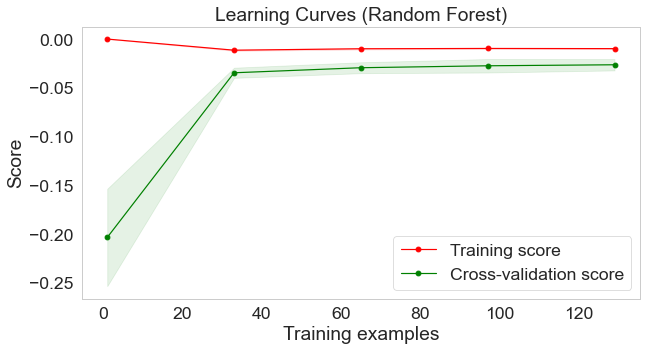

In [43]:
for key in model_cv_dict:    
    fig, axes = plt.subplots(1, 1, figsize=(10, 5))

    axes.set_title("Learning Curves ({})".format(key))

    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    
    train_sizes, train_scores, test_scores, _, _ = learning_curve(
        model_cv_dict[key],
        X_train,
        y_train,
        scoring='neg_mean_absolute_error',
        cv=10,
        n_jobs=4,
        train_sizes=np.linspace(.01, 1, 5),
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1) 
    train_scores_std = np.std(train_scores, axis=1) 
    test_scores_mean = np.mean(test_scores, axis=1) 
    test_scores_std = np.std(test_scores, axis=1) 

    # Plot learning curve
    axes.grid()
    axes.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
    )
    axes.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
    )
    axes.plot(
    train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")

In [46]:
#error analysis
rf_final = rf_cv.best_estimator_
train_error = mean_absolute_error(y_train, rf_final.predict(X_train[feature_sets['Real GDP Per Capita']]))
cv_error = np.mean(rf_cv.best_score_ * -1)
test_error = mean_absolute_error(y_test, rf_final.predict(X_test[feature_sets['Real GDP Per Capita']]))
train_error, cv_error, test_error, test_error - cv_error, cv_error - train_error

(0.009905042718084383,
 0.026424229373364916,
 0.028370724392890956,
 0.00194649501952604,
 0.016519186655280533)

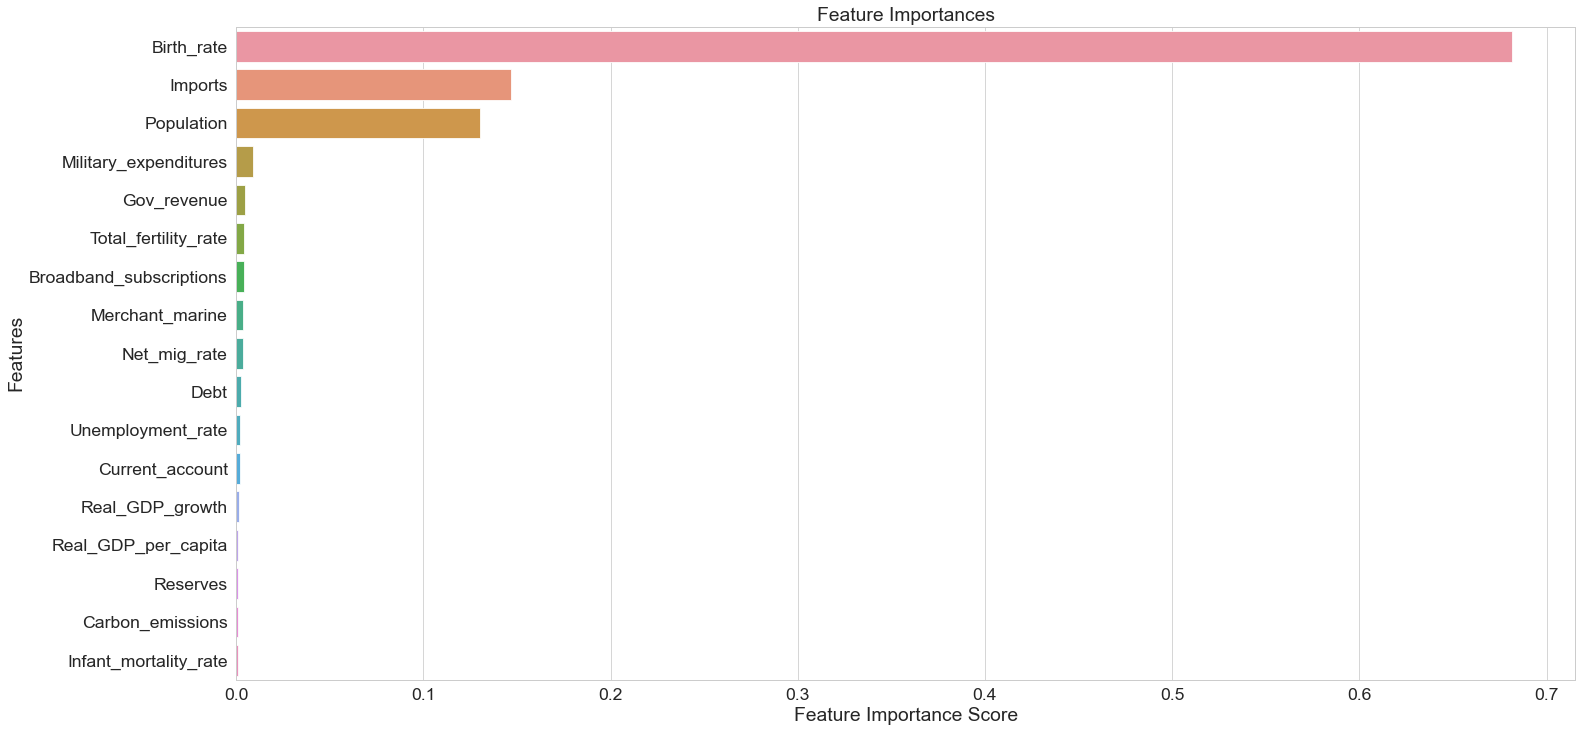

In [44]:
plt.figure(figsize=(24, 12))
#fitting RF for feature importance
feature_imp = pd.Series(rf_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_, 
                        index=X[feature_sets['Real GDP Per Capita']].columns).sort_values(ascending=False)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importances")
plt.show()

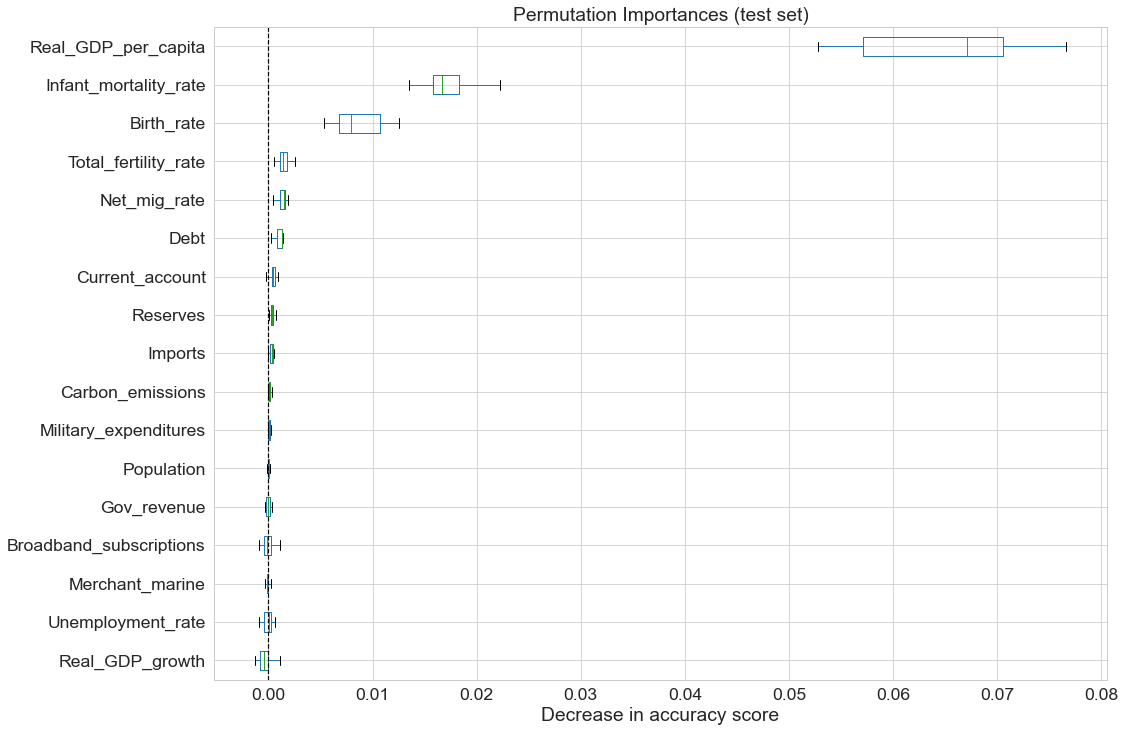

In [63]:
result = permutation_importance(
    rf_cv, X_test[feature_sets['Real GDP Per Capita']], y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X[feature_sets['Real GDP Per Capita']].columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.set_size_inches(16, 12)

<Figure size 1152x864 with 0 Axes>

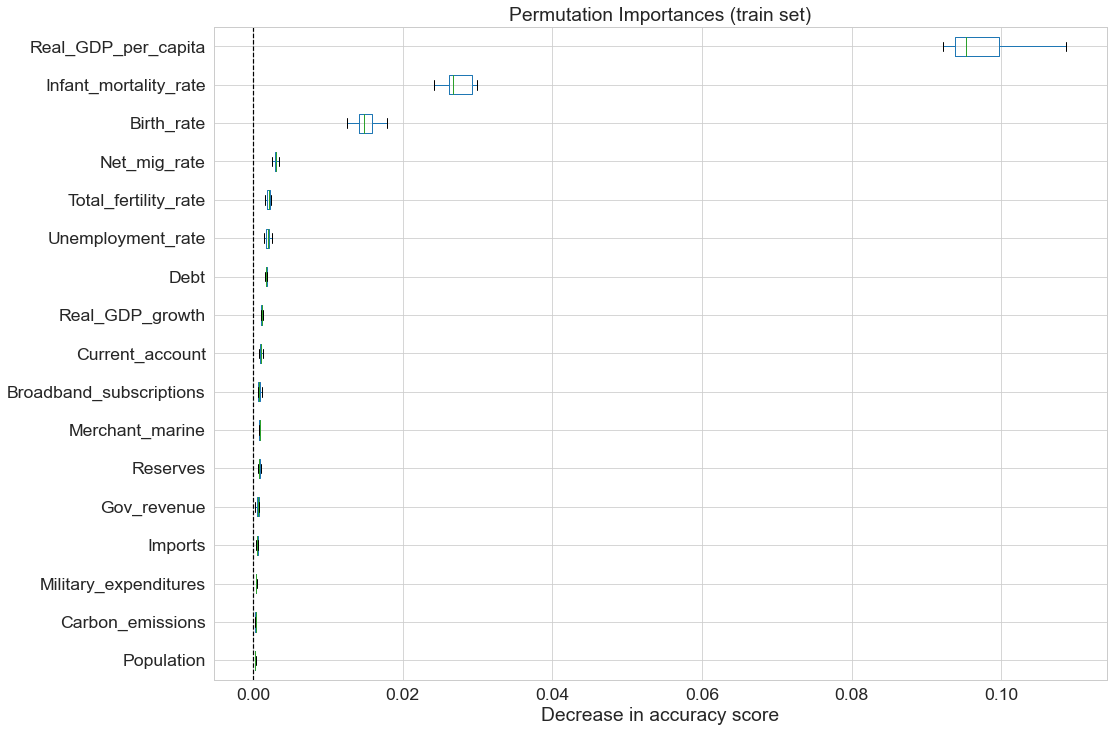

In [64]:
plt.figure(figsize=(16,12))
result = permutation_importance(
    rf_cv, X_train[feature_sets['Real GDP Per Capita']], y_train, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X[feature_sets['Real GDP Per Capita']].columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.set_size_inches(16, 12)